In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from rpy2.robjects.packages import importr

utils = importr("utils")
utils.chooseCRANmirror(ind=1)
utils.install_packages('lme4')

%load_ext rpy2.ipython

R[write to console]: trying URL 'https://cloud.r-project.org/src/contrib/lme4_1.1-27.1.tar.gz'

R[write to console]: Content type 'application/x-gzip'
R[write to console]:  length 3311365 bytes (3.2 MB)

R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to con

In [3]:
# Load data
utterances = pd.read_csv("results/intelligibility/utterances.csv")

# convert True/False to 0/1:
utterances.replace({False: 0, True: 1}, inplace=True)

utterances.head()


,response_latency,response_latency_follow_up,age,corpus,transcript_file,child_name,utt_child,utt_car,utt_child_follow_up,utt_child_intelligible,utt_car_intelligible,follow_up_intelligible,caregiver_response,caregiver_response_contingent
0,-998.0,-186.0,36,MPI-EVA-Manchester,/home/mitja/data/CHILDES/MPI-EVA-Manchester/El...,MPI-EVA-Manchester_Eleanor,oops your paint,no mess please,Daddy there's all water on your computer,1,1,1,1,1
1,251.0,3895.0,36,MPI-EVA-Manchester,/home/mitja/data/CHILDES/MPI-EVA-Manchester/El...,MPI-EVA-Manchester_Eleanor,Daddy there's all water on your computer,NaN,I want five,1,0,1,0,0
2,108.0,5.0,36,MPI-EVA-Manchester,/home/mitja/data/CHILDES/MPI-EVA-Manchester/El...,MPI-EVA-Manchester_Eleanor,if I could . very good,what number are you doing now Poppin,um these,1,1,1,1,1
3,35.0,90.0,36,MPI-EVA-Manchester,/home/mitja/data/CHILDES/MPI-EVA-Manchester/El...,MPI-EVA-Manchester_Eleanor,um these,xxx,I know who's that,1,0,1,0,0
4,11.0,4681.0,36,MPI-EVA-Manchester,/home/mitja/data/CHILDES/MPI-EVA-Manchester/El...,MPI-EVA-Manchester_Eleanor,big one,well whichever one you've got,mm no,1,1,1,1,1


In [4]:
# Some children have very few data points:
counts = utterances.groupby("child_name").size()
counts

child_name
Bernstein_Alice                    3
Bernstein_Anne                     1
Bernstein_Dale                     1
Bernstein_Gail                     3
Bernstein_Marie                    1
Braunwald_Laura                 8880
Brent_Alexander                  242
Brent_Allen                        3
Brent_Brooklyn                     8
Brent_Dillon                     814
Brent_Henry                      175
Brent_Jacob_Abernathy              4
Brent_Jaylen                      36
Brent_Maggie                     176
Brent_Miranda                    170
Brent_Morgan                     742
Brent_Tabitha                    335
Brent_Tabitha_Sims                 3
Brent_Timothy                    470
Brent_Tyrese                       6
Brent_Vas                         12
Brent_Vas_Coleman                109
Brent_Xavier                      12
MPI-EVA-Manchester_Eleanor     48244
MPI-EVA-Manchester_Fraser     103775
MacWhinney_Ross                12040
Peters_Seth                

In [5]:
# Exclude children with less than 100 datapoints:
# child_names_enough_data = [name for name, count in counts.items() if count > 100]
# print(len(utterances))
# utterances = utterances[utterances.child_name.isin(child_names_enough_data)]
# print(len(utterances))

## Caregiver Contingency
### By child

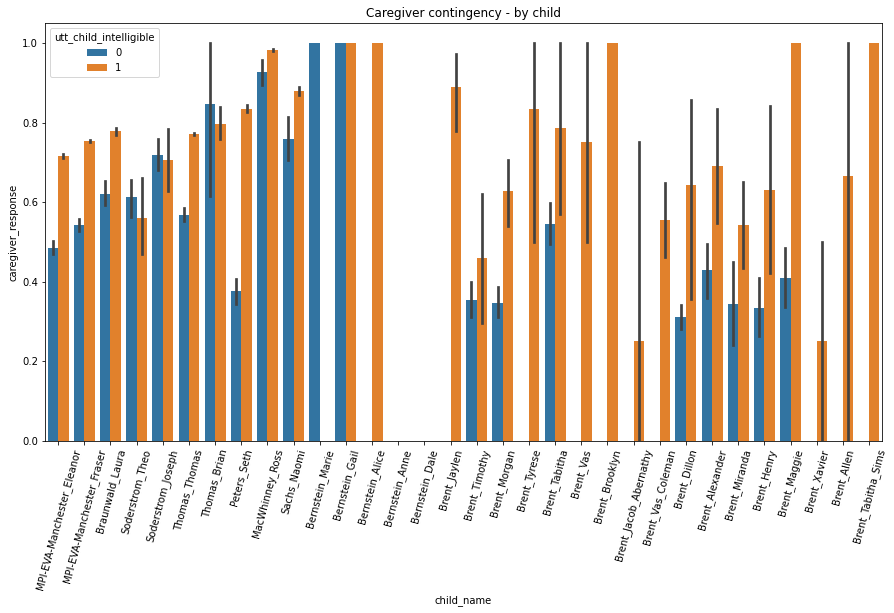

In [6]:
plt.rcParams['figure.figsize'] = [15, 10]
sns.barplot(
        data=utterances,
        x="child_name",
        y="caregiver_response",
        hue="utt_child_intelligible"
)
plt.title("Caregiver contingency - by child")
plt.xticks(rotation=75)
plt.subplots_adjust(bottom=0.3)

### By Age

Text(0.5, 1.0, 'Caregiver contingency - by age')

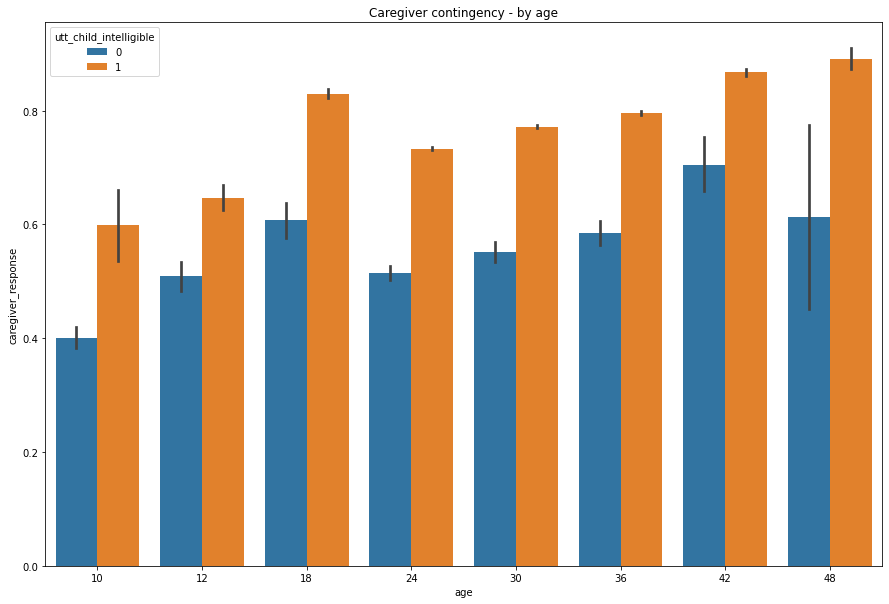

In [7]:
plt.rcParams['figure.figsize'] = [15, 10]
sns.barplot(
        data=utterances,
        x="age",
        y="caregiver_response",
        hue="utt_child_intelligible"
)
plt.title("Caregiver contingency - by age")

## Child contingency
### By Child


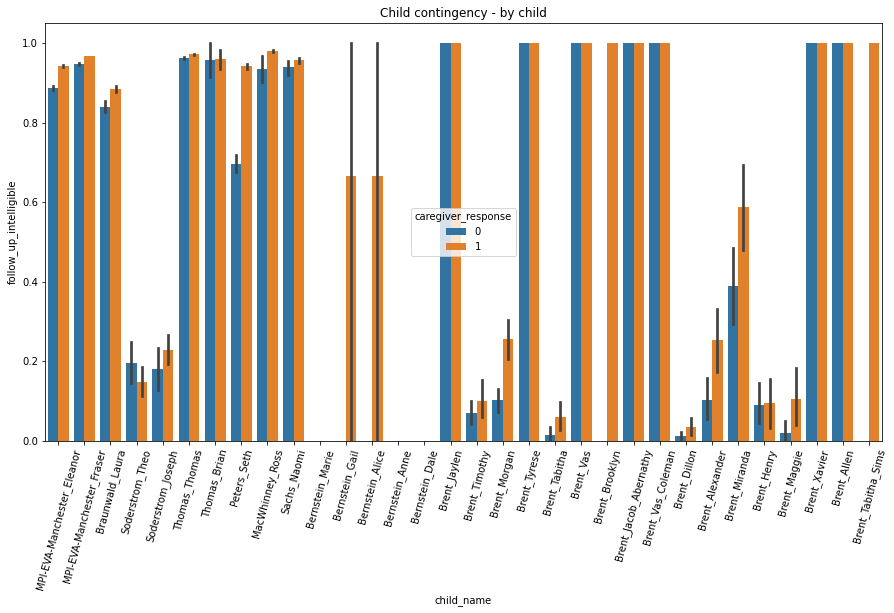

In [8]:
plt.rcParams['figure.figsize'] = [15, 10]
sns.barplot(
        data=utterances,
        x="child_name",
        y="follow_up_intelligible",
        hue="caregiver_response"
)
plt.title("Child contingency - by child")
plt.xticks(rotation=75)
plt.subplots_adjust(bottom=0.3)

### By Age

Text(0.5, 1.0, 'Child contingency - by age')

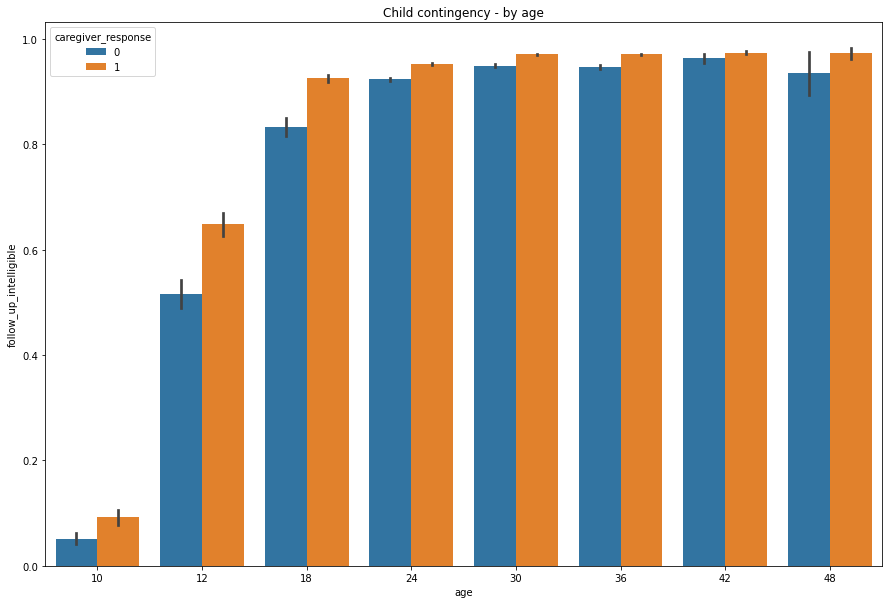

In [9]:
plt.rcParams['figure.figsize'] = [15, 10]
sns.barplot(
        data=utterances,
        x="age",
        y="follow_up_intelligible",
        hue="caregiver_response"
)
plt.title("Child contingency - by age")

## Caregiver contingency
### GLM (with mixed effects)

In [10]:
# normalize age
min_age, max_age = utterances["age"].min(), utterances["age"].max()
utterances["age"]=(utterances["age"] - min_age) / (max_age - min_age) * (1 - 0)


In [11]:
%%R -i utterances
library(lme4)

# Caregiver contingency
m_caregiver_contingency<-glmer('caregiver_response ~ utt_child_intelligible * age + (1 | child_name)', data=utterances, family=binomial) #, control=glmerControl(optimizer="bobyqa",optCtrl=list(maxfun=2e5)))
print(summary(m_caregiver_contingency))


R[write to console]: Loading required package: Matrix



Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: caregiver_response ~ utt_child_intelligible * age + (1 | child_name)
   Data: utterances

      AIC       BIC    logLik  deviance  df.resid 
 315399.8  315452.8 -157694.9  315389.8    293978 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-9.2771  0.1176  0.5479  0.5976  1.4868 

Random effects:
 Groups     Name        Variance Std.Dev.
 child_name (Intercept) 0.6246   0.7903  
Number of obs: 293983, groups:  child_name, 32

Fixed effects:
                           Estimate Std. Error z value Pr(>|z|)    
(Intercept)                -0.15517    0.11128  -1.394    0.163    
utt_child_intelligible      1.12004    0.03319  33.750  < 2e-16 ***
age                         1.44425    0.06469  22.327  < 2e-16 ***
utt_child_intelligible:age -0.34440    0.06448  -5.341 9.24e-08 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Co

### GLM (without mixed effects)

In [12]:
%%R -i utterances
library(lme4)

# Caregiver contingency
m_caregiver_contingency<-glm('caregiver_response ~ utt_child_intelligible * age', data=utterances, family=binomial) #, control=glmerControl(optimizer="bobyqa",optCtrl=list(maxfun=2e5)))
print(summary(m_caregiver_contingency))


Call:
glm(formula = "caregiver_response ~ utt_child_intelligible * age", 
    family = binomial, data = utterances)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.9434   0.6181   0.7173   0.7712   1.2844  

Coefficients:
                           Estimate Std. Error z value Pr(>|z|)    
(Intercept)                -0.24807    0.02785  -8.906   <2e-16 ***
utt_child_intelligible      0.92100    0.03168  29.070   <2e-16 ***
age                         0.92226    0.06613  13.946   <2e-16 ***
utt_child_intelligible:age  0.12905    0.07227   1.786   0.0742 .  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 327835  on 293982  degrees of freedom
Residual deviance: 321688  on 293979  degrees of freedom
AIC: 321696

Number of Fisher Scoring iterations: 4



## Child Contingency
### GLM (with mixed effects)

In [13]:
%%R -i utterances
library(lme4)

utterances_child_intelligible = subset(utterances, utt_child_intelligible==1)

# Child contingency
m_child_contingency<-glmer('follow_up_intelligible ~ caregiver_response * age + (1 | child_name)', data=utterances_child_intelligible, family=binomial)
print(summary(m_child_contingency))

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: follow_up_intelligible ~ caregiver_response * age + (1 | child_name)
   Data: utterances_child_intelligible

     AIC      BIC   logLik deviance df.resid 
 87771.7  87824.4 -43880.9  87761.7   277266 

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-10.3393   0.1613   0.1815   0.2106   1.9943 

Random effects:
 Groups     Name        Variance Std.Dev.
 child_name (Intercept) 3.198    1.788   
Number of obs: 277271, groups:  child_name, 29

Fixed effects:
                       Estimate Std. Error z value Pr(>|z|)    
(Intercept)             2.07845    0.19282  10.779  < 2e-16 ***
caregiver_response      0.43685    0.05561   7.856 3.97e-15 ***
age                     1.53582    0.09757  15.740  < 2e-16 ***
caregiver_response:age -0.03895    0.11240  -0.347    0.729    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Cor